In [52]:
import pandas as pd
# pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif


In [4]:
df = pd.read_excel('datasets/FoodInsecurity_Hispanic_Demographics_Tone_Preferences_Dataset.xlsx')

In [48]:
df.head(2)

,age,gender,ethnicity,race,education,marital_status,income,employment,language,disability,states,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8
0,45-54,female,non hispanic,native american,High School,na,"$25,000 - $49,999",Employed Part time,both,i do not have a disability,indiana,Persuasive,Simplier,Empathetic,Persuasive,Original,Original,Persuasive,Original
1,18-24,male,hispanic,white,High School,single,"Less than $25,000",Employed Part time,english,i do not have a disability,illinois,Original,Simplier,Empathetic,Simplier,Simplier,Original,Original,Persuasive


In [61]:
df.drop('states', axis=1, inplace=True)

### Reshape data

In [62]:
melted = df.copy()
id_vars = melted.columns.difference(['sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5', 'sample_6', 'sample_7', 'sample_8'])
# Melt dataframe
melted_data = pd.melt(melted, id_vars=id_vars, value_vars=['sample_1', 'sample_2', 'sample_3', 'sample_4', 'sample_5', 'sample_6', 'sample_7', 'sample_8'],value_name='tone')
melted_data.drop('variable',axis=1, inplace=True)

## Method 1: Filter

**Objective**: Combine the eight separate tone columns into a single column, allowing us to use this consolidated tone column as the target variable in our model.

In [63]:
X = melted_data.drop('tone', axis=1)
y = melted_data['tone']

In [64]:
# Apply LabelEncoder to categorical columns
label_encoders = {}
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

In [65]:
# Apply OneHotEncoder to categorical columns
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_encoded = encoder.fit_transform(X.select_dtypes(include=['object']))
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out())
X = pd.concat([X.drop(columns=X.select_dtypes(include=['object']).columns), X_encoded_df], axis=1)

In [66]:
y = LabelEncoder().fit_transform(y)

In [100]:
from sklearn.feature_selection import f_classif

# Assuming X and y are now numeric
F_values, p_values = f_classif(X, y)

# Create a DataFrame to view results
results = pd.DataFrame({
    'Feature': X.columns,
    'F-Value': F_values,
    'P-Value': p_values
})

# Select features with significant p-values
significant_features = results[results['P-Value'] < 0.18]

In [101]:
results

,Feature,F-Value,P-Value
0,age,2.532329,0.056678
1,disability,0.903145,0.439614
2,education,0.417625,0.740448
3,employment,1.720474,0.162207
4,ethnicity,0.779992,0.505654
5,gender,0.503643,0.679974
6,income,1.618545,0.184506
7,language,0.279639,0.840097
8,marital_status,1.781128,0.150174
9,race,0.630945,0.595398


In [102]:
significant_features

,Feature,F-Value,P-Value
0,age,2.532329,0.056678
3,employment,1.720474,0.162207
8,marital_status,1.781128,0.150174


In [104]:
from sklearn.feature_selection import chi2

In [105]:
from sklearn.feature_selection import chi2

# Apply Chi-Square test
chi2_values, p_values = chi2(X, y)

# Create a DataFrame to view results
results = pd.DataFrame({
    'Feature': X.columns,
    'Chi2-Value': chi2_values,
    'P-Value': p_values
})

# Display results
print(results)

# Select features with significant p-values
significant_features = results[results['P-Value'] < 0.05]
print()

          Feature  Chi2-Value   P-Value
0             age    9.999206  0.018573
1      disability    2.555113  0.465413
2       education    2.335436  0.505766
3      employment    8.880465  0.030923
4       ethnicity    1.409831  0.703232
5          gender    0.989650  0.803756
6          income    3.950708  0.266836
7        language    0.943562  0.814905
8  marital_status    5.079575  0.166062
9            race    2.597910  0.457856
      Feature  Chi2-Value   P-Value
0         age    9.999206  0.018573
3  employment    8.880465  0.030923


In [107]:
results

,Feature,Chi2-Value,P-Value
0,age,9.999206,0.018573
1,disability,2.555113,0.465413
2,education,2.335436,0.505766
3,employment,8.880465,0.030923
4,ethnicity,1.409831,0.703232
5,gender,0.989650,0.803756
6,income,3.950708,0.266836
7,language,0.943562,0.814905
8,marital_status,5.079575,0.166062
9,race,2.597910,0.457856


In [106]:
significant_features

,Feature,Chi2-Value,P-Value
0,age,9.999206,0.018573
3,employment,8.880465,0.030923


In [115]:
from sklearn.cluster import KMeans

# Use the significant features for clustering
X_significant = X[significant_features['Feature']]

# Apply clustering algorithm
kmeans = KMeans(n_clusters=3, n_init=10)
clusters = kmeans.fit_predict(X_significant)


In [110]:
# Example: Analyzing how a categorical feature distributes across clusters
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(clusters, X['age'])

# Perform Chi-Square test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi2 Stat: {chi2_stat}, P-Value: {p_val}")





Chi2 Stat: 424.2022792022792, P-Value: 2.8150726747636976e-83


In [113]:
X

,age,disability,education,employment,ethnicity,gender,income,language,marital_status,race
0,3,0,3,1,1,0,1,0,2,7
1,0,0,3,1,0,1,4,1,4,8
2,1,0,0,4,1,0,4,1,4,5
3,1,0,0,1,0,0,4,0,4,6
4,0,1,1,4,0,1,1,0,4,7
...,...,...,...,...,...,...,...,...,...,...
395,6,0,0,0,1,0,4,1,1,4
396,1,0,0,3,1,1,1,1,4,8
397,1,0,1,4,0,0,5,0,4,8
398,1,0,1,1,1,1,2,0,4,4


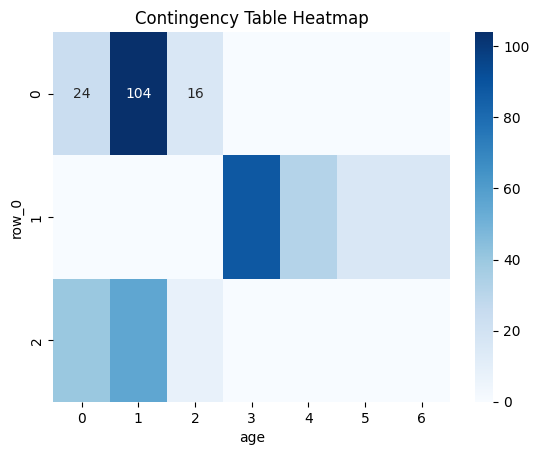

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a contingency table
contingency_table = pd.crosstab(clusters, X['age'])

# Visualize the contingency table
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='Blues')
plt.title('Contingency Table Heatmap')
plt.show()

## Method 2: Recursive Feature Elimination

### Pipeline

In [35]:
categorical_features = X.select_dtypes(include=['object']).columns

In [36]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

In [37]:
X_encoded = preprocessor.fit_transform(X)

In [38]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [39]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(estimator=model, n_features_to_select=10)  # Adjust as needed

# Fit RFE
rfe.fit(X_encoded, y_encoded)

# Get selected features
feature_names = preprocessor.get_feature_names_out()
selected_features = feature_names[rfe.support_]
print("Selected features:", selected_features)

Selected features: ['cat__age_25-34' 'cat__education_Associate'
 'cat__employment_Employed Part time' 'cat__gender_female'
 'cat__income_$25,000 - $49,999' 'cat__language_english'
 'cat__marital_status_married' 'cat__race_white' 'cat__states_illinois'
 'cat__states_new jersey']


In [42]:
from sklearn.model_selection import train_test_split


In [43]:
# Encode categorical variables
le = LabelEncoder()
df_encoded = melted_data.apply(le.fit_transform)

# Separate features and target
X = df_encoded.drop(columns=['tone'])
y = df_encoded['tone']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Initialize RFE with the model and set the number of features to select
rfe = RFE(estimator=model, n_features_to_select=1)

# Fit RFE
rfe.fit(X_train, y_train)

# Get ranking of features
ranking = rfe.ranking_
feature_names = X.columns

# Print feature ranking
print("Feature ranking:")
for i in range(len(feature_names)):
    print(f"{feature_names[i]}: {ranking[i]}")

# Select features with rank 1 (most significant)
selected_features = feature_names[rfe.support_]
print("Selected features:", selected_features)

Feature ranking:
age: 10
disability: 1
education: 8
employment: 4
ethnicity: 2
gender: 3
income: 5
language: 7
marital_status: 9
race: 11


IndexError: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 11